In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit_aer import backends
from qiskit import transpile
from qiskit.quantum_info.operators import Operator
import numpy as np
from typing import List

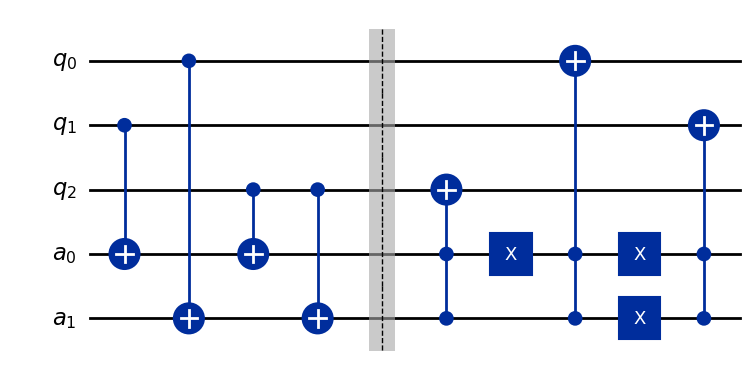

In [3]:
qrfc = QuantumRegister(3, name = 'q')
arfc = AncillaRegister(2, name = 'a')
qcfc = QuantumCircuit(qrfc, arfc, name = 'corrrr')

qcfc.cx(qrfc[1], arfc[0])
qcfc.cx(qrfc[2], arfc[0])
qcfc.cx(qrfc[0], arfc[1])
qcfc.cx(qrfc[2], arfc[1])

qcfc.barrier()

qcfc.ccx(arfc[0], arfc[1], qrfc[2])
qcfc.x(arfc[0])
qcfc.ccx(arfc[0], arfc[1], qrfc[0])
qcfc.x(arfc[0])
qcfc.x(arfc[1])
qcfc.ccx(arfc[0], arfc[1], qrfc[1])

qcfc.initialize(0, arfc)

corrrr = qcfc.to_instruction()


In [ ]:
def add_corrections(cwe):
    nq = cwe.num_qubits
    nc = cwe.num_clbits
    data = cwe.data

    qreg = QuantumRegister(nq)
    qreg2 = QuantumRegister(nq)
    qreg3 = QuantumRegister(nq)
    creg = ClassicalRegister(nc)
    anc = AncillaRegister(2)

    cqc = QuantumCircuit(qreg, qreg2, qreg3, anc, creg)

    for i in range(len(data)):
        inst = data[i]
        qb = inst.qubits
        cb = inst.clbits
        
        qbi = list(())
        cbi = list(())
        qbi2 = list(())
        qbi3 = list(())
        
        for b in qb:
            ind = b._index
            qbi.append(qreg[ind])
            qbi2.append(qreg2[ind])
            qbi3.append(qreg3[ind])

        if (len(cb) > 0):
            for ii in range(len(qb)):
                cqc.append(corrrr, [qbi[ii], qbi2[ii], qbi3[ii], anc[0], anc[1]])

            for b in cb:
                ind = b._index
                cbi.append(creg[ind])
            cqc.append(inst.replace(qubits = qbi, clbits = cbi))

        else:
            if (i % 3 == 0):
                for ii in range(len(qb)):
                   cqc.append(corrrr, [qbi[ii], qbi2[ii], qbi3[ii], anc[0], anc[1]])
                    
            cqc.append(inst.replace(qubits = qbi))
            cqc.append(inst.replace(qubits = qbi2))
            cqc.append(inst.replace(qubits = qbi3))
    
    return cqc